# Literature Review and Preliminary Exploratory Data Analysis

## Setup and Imports

In [1]:
%matplotlib inline
import os
import requests
import tqdm

import zipfile
import lzma
import json

import gzip
import csv

import pandas as pd

from matplotlib import pylab as plt
import seaborn as sns

from itertools import islice

### Data Description


> CAP includes all official, book-published United States case law — every volume designated as an official report of decisions by a court within the United States.
>
>Each volume has been converted into structured, case-level data broken out by majority and dissenting opinion, with >human-checked metadata for party names, docket number, citation, and date.
>
> -- <cite>[Case.law][1]</cite>

In the scope of this analysis we use the latest open case text from from bulk data exxports of open jurisdictions in the dataset. This subset consists of caselaws and metadata for the following four Jurisdictions:

1. ark - Arkansas
2. ill - Illinois
3. nc - North Carolina
4. nm - New Mexico

These were downloaded from [here][2].


**Citation Graph**

In addition to the case text we also use the case citation graph that links extracted, verified and unambiguous  citations to cases within the dataset. We use the citation graph from [2021-04-20][3] for this study. The citation graph is present in the form of a edgelist linking one case_id to multiple case_ids. It also contains all the references to all nodes from the case.law dataset. We truncate the graph based on case_ids we found in the case texts for each jurisdiction during preprocessing.

[1]: https://case.law/about/
[2]: https://case.law/download/bulk_exports/latest/by_jurisdiction/case_text_open/
[3]: https://case.law/download/citation_graph/2021-04-20/


In [2]:
##filename declarations

base_url = "https://case.law/download/bulk_exports/latest/by_jurisdiction/case_text_open/"
base_folder = "../data"
folder_names = ["ark", "ill", "nc", "nm"]
for item in folder_names:
    os.makedirs(f"{base_folder}/{item}", exist_ok=True)

def get_url_loc(file_name, base_url=base_url, base_folder=base_folder):
    url = os.path.join(base_url, file_name)
    file_loc = os.path.join(base_folder, file_name)
    return url, file_loc    
    
    
text_file_names = [f"{item}/{item}_text.zip" for item in folder_names]
xml_file_names = [f"{item}/{item}_xml.zip" for item in folder_names]

text_file_url_locs = list(map(get_url_loc, text_file_names))
xml_file_url_locs = list(map(get_url_loc, xml_file_names))

## Data Loading and Clean-up

In [3]:
def load_cases(fnames, field="id"):
    cases = []
    for fname in fnames:
        with zipfile.ZipFile(fname, 'r') as zip_archive:
            xz_path = next(path for path in zip_archive.namelist() if path.endswith('/data.jsonl.xz'))
            with zip_archive.open(xz_path) as xz_archive, lzma.open(xz_archive) as jsonlines:
                for line in tqdm.tqdm_notebook(jsonlines):
                    record = json.loads(str(line, 'utf-8'))
                    if field:
                        record = {field: record[field]}
                    cases.append(record)
    return pd.DataFrame(cases)

def read_citation_graph(fname, case_ids):
    csvobj = csv.reader(gzip.open(fname, mode='rt'),delimiter = ',',quotechar="'")
    graph = []
    for item in tqdm.tqdm_notebook(csvobj):
        head = item[0]
        try:
            head = int(head)
        except ValueError:
            head = None
        if head in case_ids:
            graph.append(item)
    citation_graph = pd.DataFrame(graph)
    citation_graph = citation_graph.set_index(0)
    citation_graph = citation_graph.apply(lambda x: x.dropna().tolist(), axis=1)
    return citation_graph


def read_citiation_metadata(fname, case_ids):
    csvobj = csv.DictReader(gzip.open(fname, mode='rt'),delimiter = ',')
    graph_meta = []
    for item in tqdm.tqdm_notebook(csvobj):
        head = item["id"]
        try:
            head = int(head)
        except ValueError:
            head = None
        if head in case_ids:
            graph_meta.append(item)
    graph_meta = pd.DataFrame(graph_meta).set_index("id")
    return graph_meta

In [29]:
_, text_fnames= zip(*text_file_url_locs)
cases_data = load_cases(text_fnames, field=None)

<ipython-input-3-7821ca5bd822>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for line in tqdm.tqdm_notebook(jsonlines):


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [30]:
print(f"Total number of cases in the raw dataset : {len(cases_data)}")
print(f"Total number of columns in the raw dataset : {len(cases_data.columns)}")

Total number of cases in the raw dataset : 358706
Total number of columns in the raw dataset : 17


In [31]:
##view the first case
sample_case = cases_data.iloc[0,:].to_json()
#fix for escape chars
sample_case = json.dumps(json.loads(sample_case), indent=2)
print(sample_case)

{
  "id": 1869772,
  "url": "https://api.capapi.org/v1/cases/1869772/",
  "name": "James Joseph STANDLEY, Jr. v. STATE of Arkansas",
  "name_abbreviation": "Standley v. State",
  "decision_date": "1987-11-09",
  "docket_number": "",
  "first_page": "517",
  "last_page": "518",
  "citations": [
    {
      "cite": "293 Ark. 517",
      "type": "official"
    },
    {
      "cite": "738 S.W.2d 423",
      "type": "parallel"
    }
  ],
  "volume": {
    "volume_number": "293",
    "barcode": "32044078577145",
    "url": "https://api.capapi.org/v1/volumes/32044078577145/"
  },
  "reporter": {
    "id": 368,
    "full_name": "Arkansas Reports",
    "url": "https://api.capapi.org/v1/reporters/368/"
  },
  "court": {
    "name_abbreviation": "Ark.",
    "name": "Arkansas Supreme Court",
    "id": 8808,
    "slug": "ark",
    "url": "https://api.capapi.org/v1/courts/ark/"
  },
  "jurisdiction": {
    "name": "Ark.",
    "id": 34,
    "slug": "ark",
    "name_long": "Arkansas",
    "url": "http

In [32]:
#get columns with any empty values
cases_data.applymap(lambda x: True if x else False).all(axis=0)

id                    True
url                   True
name                  True
name_abbreviation     True
decision_date         True
docket_number        False
first_page            True
last_page             True
citations             True
volume                True
reporter              True
court                 True
jurisdiction          True
cites_to             False
frontend_url          True
preview              False
casebody              True
dtype: bool

In [33]:
# initally looks like `preview` and `docket_number` are sparse and don't really matter for the problem.
# we'll get the citation information after linking the citation graph
drop_cols = ["docket_number", "preview","cites_to", "citations"]
cases_data = cases_data.drop(drop_cols, axis=1)

In [38]:
# convert the id to int for indexing
cases_data["id"] = cases_data["id"].astype(int)
cases_data = cases_data.set_index("id")

In [40]:
# convert date column
# cases_data["decision_date"] = pd.to_datetime(cases_data["decision_date"], format="%Y-%m-%d", errors="coerce")
cases_data[cases_data["decision_date"].isnull()]["decision_date"]

244274   NaT
Name: decision_date, dtype: datetime64[ns]

In [41]:
# feb 29 1914
cases_data = cases_data[cases_data["decision_date"].notnull()]

In [42]:
## extract and normalize volumes
volumes_data = pd.DataFrame(cases_data.volume.tolist(), index=cases_data.index)
volumes_data.loc[:, "volume_number"] = volumes_data["volume_number"].astype(int)
cases_data.loc[:, "volume_id"] = volumes_data["volume_number"]
volumes_data = volumes_data.drop_duplicates("volume_number")

In [43]:
# volumes_data.to_csv("data/subset/volumes.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [44]:
# extract and normalize reporters
reporters_data = pd.DataFrame(cases_data["reporter"].tolist(), index=cases_data.index)
reporters_data.loc[:, "id"] = reporters_data["id"].astype(int)
cases_data.loc[:, "reporter_id"] = reporters_data["id"]
reporters_data = reporters_data.drop_duplicates("id")

/Users/bebop/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


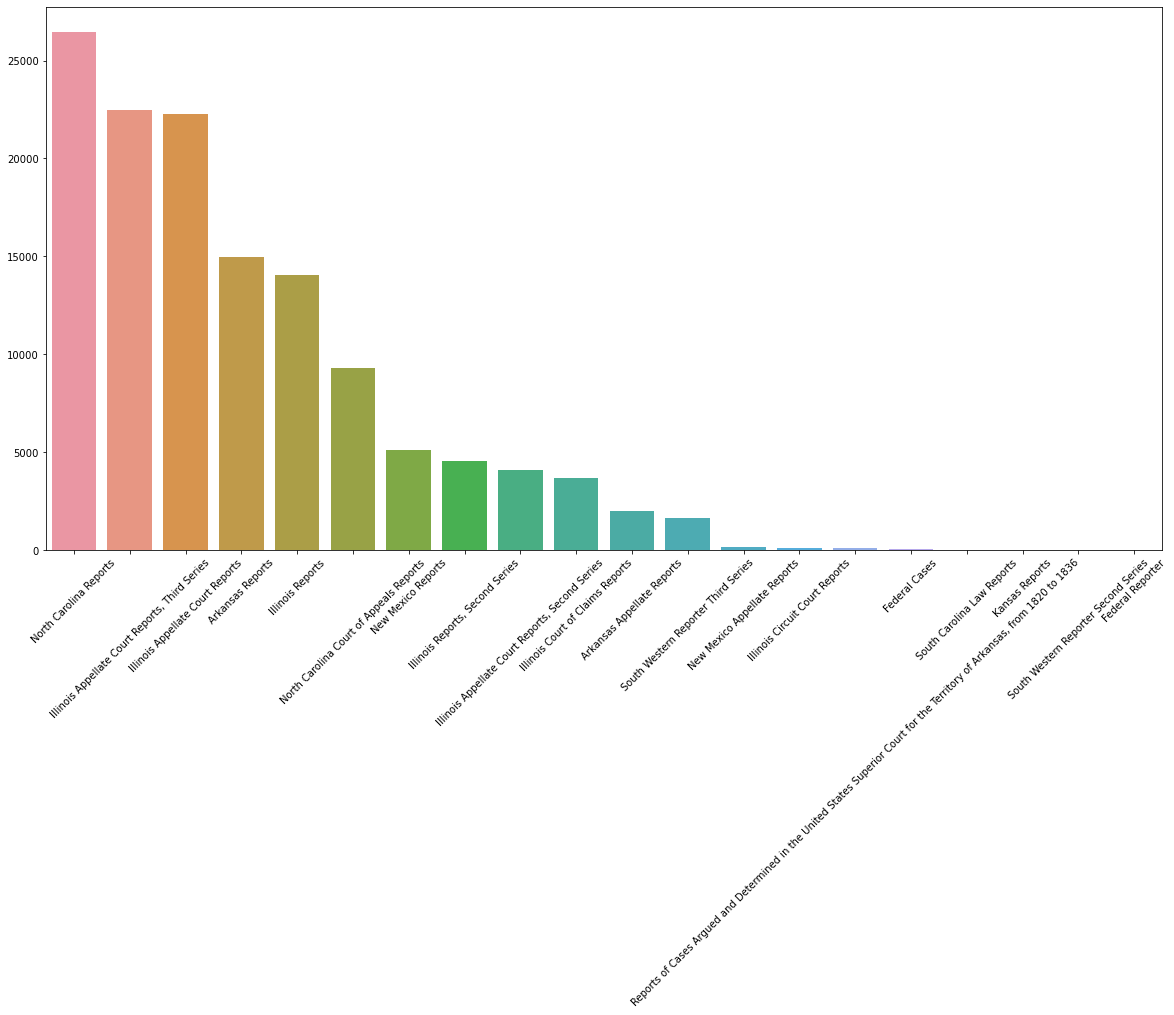

In [87]:
cases_by_reporters = cases_data.reporter_id.value_counts()
reporter_names = reporters_data.set_index("id").loc[cases_by_reporters.index, "full_name"].tolist()
plt.figure(figsize=(20,10))
sns.barplot(reporter_names, cases_by_reporters.values)
plt.xticks(rotation=45)
plt.show()

In [45]:
# reporters_data.to_csv("data/subset/reporters.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [46]:
# extract and normalize courts
courts_data = pd.DataFrame(cases_data["court"].tolist(), index=cases_data.index)
courts_data.loc[:, "id"] = courts_data["id"].astype(int)
cases_data.loc[:, "court_id"] = courts_data["id"]
courts_data = courts_data.drop_duplicates("id")

/Users/bebop/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


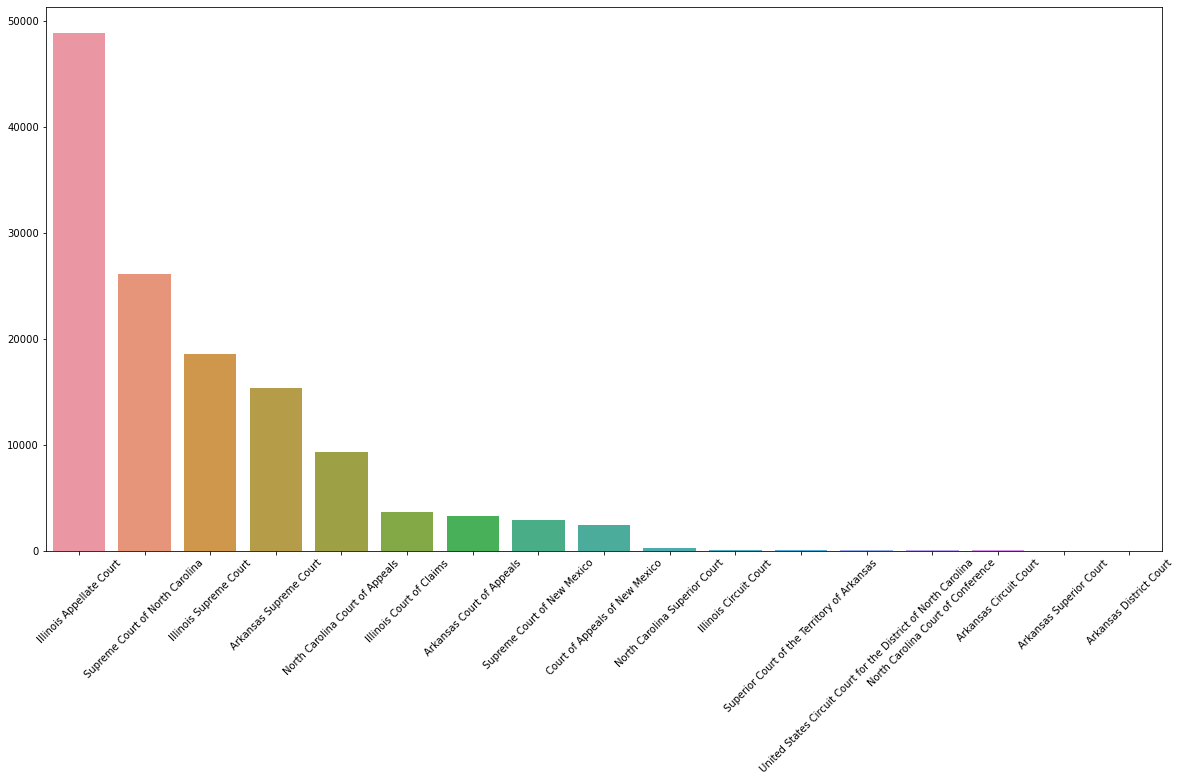

In [89]:
cases_by_courts = cases_data.court_id.value_counts()
court_names = courts_data.set_index("id").loc[cases_by_courts.index, "name"].tolist()
plt.figure(figsize=(20,10))
sns.barplot(court_names, cases_by_courts.values)
plt.xticks(rotation=45)
plt.show()

In [47]:
# courts_data.to_csv("data/subset/courts.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [48]:
# extract and normalize jurisdictions
jurisdictions_data = pd.DataFrame(cases_data["jurisdiction"].tolist(), index=cases_data.index)
jurisdictions_data.loc[:,"id"] = jurisdictions_data["id"].astype(int)
cases_data.loc[:, "jurisdiction_id"] = jurisdictions_data["id"]
jurisdictions_data = jurisdictions_data.drop_duplicates("id")

/Users/bebop/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


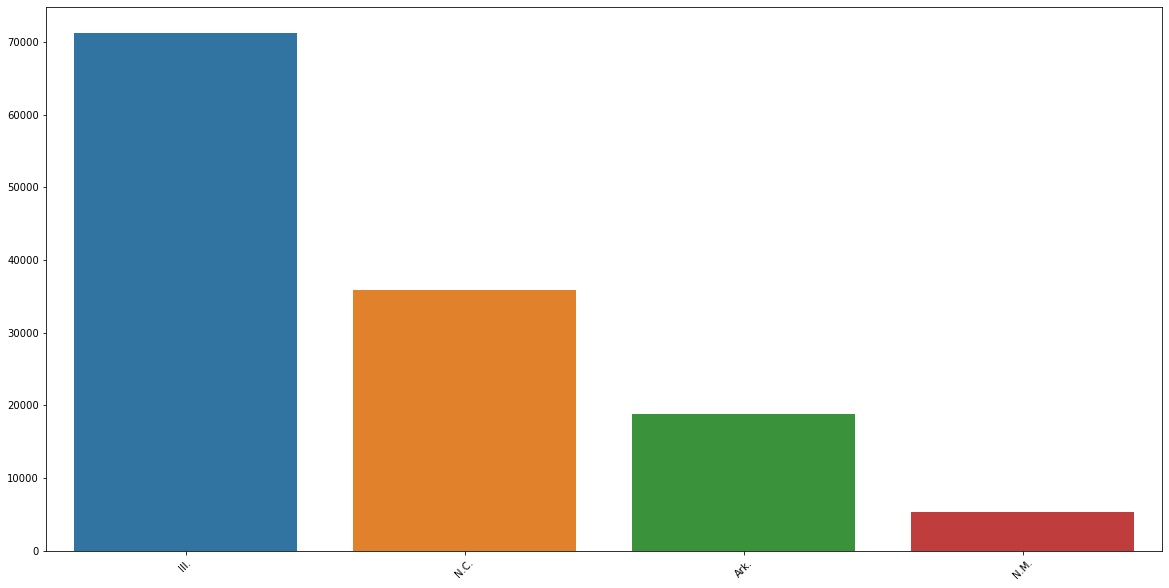

In [91]:
cases_by_jurisdictions = cases_data.jurisdiction_id.value_counts()
jurisdiction_names = jurisdictions_data.set_index("id").loc[cases_by_jurisdictions.index, "name"].tolist()
plt.figure(figsize=(20,10))
sns.barplot(jurisdiction_names, cases_by_jurisdictions.values)
plt.xticks(rotation=45)
plt.show()

In [49]:
# jurisdictions_data.to_csv("data/subset/jurisdictions.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')

In [50]:
# extract case opinion and headmatter
casebody_data = pd.DataFrame(cases_data.loc[:, "casebody"].map(lambda x: x.get("data")).tolist(), index=cases_data.index)
cases_data.loc[: , "head_matter"] = casebody_data.loc[:, "head_matter"]
cases_data.loc[: , "opinion_text"] = casebody_data.loc[:,"opinions"].map(lambda x: "\n".join(y.get("text", "") for y in x))
cases_data["head_matter"] = cases_data["head_matter"]
cases_data["opinion_text"] = cases_data["opinion_text"]

In [ ]:
cases_data.head_matter.map(len).value_counts

In [107]:
# head_matter_lengths = cases_data.head_matter.map(len).value_counts(sort=False, bins=10, dropna=True)


IntervalIndex([(-282.84099999999995, 28284.0], (28284.0, 56568.0], (56568.0, 84852.0], (84852.0, 113136.0], (113136.0, 141420.0], (141420.0, 169704.0], (169704.0, 197988.0], (197988.0, 226272.0], (226272.0, 254556.0], (254556.0, 282840.0]],
              closed='right',
              dtype='interval[float64]')

In [106]:
opinion_text_lengths = cases_data.opinion_text.map(len).value_counts(sort=False, bins=10, dropna=True)
opinion_text_lengths

(-390.44599999999997, 39044.5]    127826
(39044.5, 78089.0]                  2943
(78089.0, 117133.5]                  288
(117133.5, 156178.0]                  53
(156178.0, 195222.5]                  12
(195222.5, 234267.0]                   4
(234267.0, 273311.5]                   3
(273311.5, 312356.0]                   0
(312356.0, 351400.5]                   1
(351400.5, 390445.0]                   1
Name: opinion_text, dtype: int64

In [ ]:
opinion_text_lengths = cases_data.opinion_text.map(len).value_counts()
plt.figure(figsize=(20,10))
sns.barplot(opinion_text_lengths.index, opinion_text_lengths.values)
plt.show()

In [51]:
#read citation graph and link nodes
citation_graph = read_citation_graph("../data/citations.csv.gz", case_ids=frozenset(cases_data.index))
print(f"found and loaded {len(citation_graph)} nodes into citation_graph")

#create a lookup for our cases
citations_uids = frozenset(citations_uids.index)

# remove citations that aren't in case data
citation_graph = citation_graph.loc[:].map(lambda x: list(filter(lambda y: y in citations_uids, x)))

# remove cases with no citations after truncation
citation_graph = citation_graph[citation_graph.map(len) > 0]
citation_graph.index = citation_graph.index.astype(int)

cases_data.loc[citation_graph.index, "citation_ids"] = citation_graph.values
cases_data = cases_data[cases_data.citation_ids.notnull()]


<ipython-input-3-7821ca5bd822>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for item in tqdm.tqdm_notebook(csvobj):


0it [00:00, ?it/s]

In [ ]:
required_case_cols = [
    'decision_date', 'name', 'name_abbreviation',
    'frontend_url', 'url', 
    #'head_matter', 'opinion_text', 
    'volume_id', 'reporter_id', 'court_id', 'jurisdiction_id',]
#     'citation_ids']
# cases_data[required_case_cols].reset_index().to_csv("data/subset/cases.csv", index=False, index_label=False, quoting=csv.QUOTE_ALL, quotechar='"')


In [ ]:
citations_data = cases_data["citation_ids"].explode().reset_index()
citations_data.columns = ["src", "dst"]
# citations_data.to_csv("data/subset/citations.csv", index=False, index_label=False,)


In [212]:
citations_data = pd.read_csv("../data/subset/citations.csv")

/Users/bebop/anaconda3/envs/cs109b/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


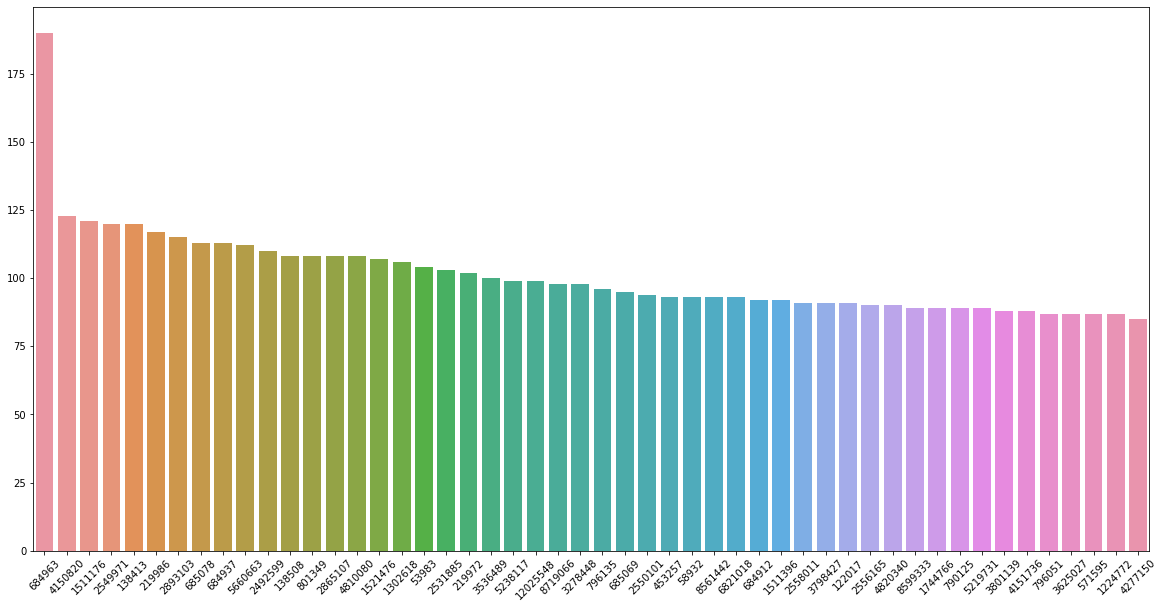

In [228]:
top_cited = citations_data.src.value_counts().head(50)
plt.figure(figsize=(20,10))
ax = sns.barplot(top_cited.index, top_cited.values, order=top_cited.index)
plt.xticks(rotation=45)
plt.show()

In [229]:
citations_data.src.value_counts().mean()

7.365593946713925

In [ ]:
citations_data.groupby("src").count

In [ ]:
cases_data.groupby(["court_id", "jurisdiction_id"]).agg({"citation_ids": sum})

In [ ]:
casebody_data.loc[cases_data.index].reset_index().to_json("../data/subset/casebody.json", lines=True, orient="records")

In [ ]:
attorney_names = [item for sublist in casebody_data.attorneys.tolist() for item in sublist]

docker run \
    --name caselaw-neo4j \
    -p7474:7474 -p7687:7687 \
    -d \
    -v /Users/bebop/Documents/courses/CS109/project/neo4j/data:/data \
    -v /Users/bebop/Documents/courses/CS109/project/neo4j/logs:/logs \
    -v /Users/bebop/Documents/courses/CS109/project/neo4j/import:/var/lib/neo4j/import \
    -v /Users/bebop/Documents/courses/CS109/project/neo4j/plugins:/plugins \
    -e NEO4J_apoc_export_file_enabled=true \
    -e NEO4J_apoc_import_file_enabled=true \
    -e NEO4J_apoc_import_file_use__neo4j__config=true \
    --env NEO4J_AUTH='neo4j/zaq!0pl' \
    --env NEO4JLABS_PLUGINS='["apoc", "graph-data-science"]' \
    neo4j:latest

In [124]:
sample_caseline = islice(open("../data/subset/caselines.txt"), 100)

In [191]:
class CaselineIterator:
    def __init__(self, fname, slice_size=None):
        self.fname = fname
        self.slice_size=slice_size
        self._length = slice_size
    def __iter__(self):
        if self.slice_size:
            iterator = islice(open(self.fname), self.slice_size)
        else:
            iterator = open(self.fname)
        for line in iterator:
            yield line.split()
            
    def __len__(self):
        if not self._length:
            self._length = sum(1 for _ in open(self.fname))
        return self._length

case_lines = CaselineIterator("../data/subset/caselines.txt", slice_size=100)

In [192]:
len(case_lines)

100

In [193]:
import logging
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.similarities import SparseMatrixSimilarity
import numpy as np

In [194]:
dictionary = Dictionary(case_lines)
dictionary.filter_extremes(no_below=5, no_above=0.75)
dictionary.compactify()

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : built Dictionary(4142 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...) from 100 documents (total 32328 corpus positions)
INFO : Dictionary lifecycle event {'msg': "built Dictionary(4142 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...) from 100 documents (total 32328 corpus positions)", 'datetime': '2021-04-28T13:23:33.198427', 'gensim': '4.0.1', 'python': '3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:12:38) \n[Clang 11.0.1 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO : discarding 3443 tokens: [('abundance', 2), ('afraid', 2), ('afternoon', 4), ('aggravated', 1), ('ahead', 4), ('amply', 3), ('appellant', 99), ('appellee', 93), ('article', 3), ('billy', 3)]...
INFO : keeping 699 tokens which were in no less than 5 and no more than 75 (=75.0%) documents
INFO : resulting dictionary: Dictionary(699 unique tokens: ['

In [199]:
class CaselawCorpus():
    def __init__(self, iterator, dictionary, **kwargs):
        self.iterator = iterator
        self.dictionary = dictionary
        
    def __iter__(self):
        for line in self.iterator:
            # assume there's one document per line, tokens separated by whitespace
            yield self.dictionary.doc2bow(line)
    def __len__(self):
        return len(self.iterator)
            
caselaw_corpus = CaselawCorpus(case_lines, dictionary, slice_size=100)

In [200]:
len(caselaw_corpus)

100

In [201]:
tfidf = TfidfModel(caselaw_corpus)
tfidf_corpus = tfidf[caselaw_corpus]

INFO : collecting document frequencies
INFO : PROGRESS: processing document #0
INFO : TfidfModel lifecycle event {'msg': 'calculated IDF weights for 100 documents and 699 features (8615 matrix non-zeros)', 'datetime': '2021-04-28T13:24:03.459978', 'gensim': '4.0.1', 'python': '3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:12:38) \n[Clang 11.0.1 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'initialize'}


In [202]:
index = SparseMatrixSimilarity(
    tfidf_corpus, 
    num_features=len(dictionary),
    num_terms=len(dictionary),
    num_docs=len(caselaw_corpus),
    num_best=10,
    maintain_sparsity=True
)

INFO : creating sparse index
INFO : creating sparse matrix from corpus
INFO : PROGRESS: at document #0
INFO : created <100x699 sparse matrix of type '<class 'numpy.float32'>'
	with 8615 stored elements in Compressed Sparse Row format>


In [186]:
a = index[tfidf_corpus]
# https://stackoverflow.com/a/52304675
def top_n_idx_sparse(matrix, n):
    '''Return index of top n values in each row of a sparse matrix'''
    top_n_idx = []
    for le, ri in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        n_row_pick = min(n, ri - le)
        top_n_idx.append(matrix.indices[le + np.argpartition(matrix.data[le:ri], -n_row_pick)[-n_row_pick:]])
    return top_n_idx

In [204]:
class BaselineModel:
    def __init__(self, no_below=5, no_above=0.75):
        self.dictionary = None
        self.corpus = None
        self.model = None
        self.index = None
        self.no_below=no_below
        self.no_above=no_above
    
    def fit(self, texts, **kwargs):
        self.dictionary = Dictionary(texts)
        self.dictionary.filter_extremes(self.no_below, self.no_above)
        self.dictionary.compactify()
        
        self.corpus = CaselawCorpus(texts, self.dictionary,**kwargs)
        self.model = TfidfModel(self.corpus)
        
        self.index = SparseMatrixSimilarity(
            tfidf_corpus, 
            num_features=len(self.dictionary),
            num_terms=len(self.dictionary),
            num_docs=len(self.corpus),
            maintain_sparsity=True)
        
        return self
    
    def predict(self, texts, top_k=5):
        pred_corpus = [self.dictionary.doc2bow(item) for item in texts]
        pred_vecs = self.model[pred_corpus]
        pred_sims = self.index[pred_vecs]
        preds = top_n_idx_sparse(pred_sims, top_k)
        return preds

In [206]:
case_lines = CaselineIterator("../data/subset/caselines.txt", slice_size=100)

In [207]:
baseline_model = BaselineModel()

In [208]:
baseline_model.fit(case_lines)

INFO : adding document #0 to Dictionary(0 unique tokens: [])
INFO : built Dictionary(4142 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...) from 100 documents (total 32328 corpus positions)
INFO : Dictionary lifecycle event {'msg': "built Dictionary(4142 unique tokens: ['abundance', 'admissible', 'affirmed', 'afraid', 'afternoon']...) from 100 documents (total 32328 corpus positions)", 'datetime': '2021-04-28T13:33:48.730702', 'gensim': '4.0.1', 'python': '3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:12:38) \n[Clang 11.0.1 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO : discarding 3443 tokens: [('abundance', 2), ('afraid', 2), ('afternoon', 4), ('aggravated', 1), ('ahead', 4), ('amply', 3), ('appellant', 99), ('appellee', 93), ('article', 3), ('billy', 3)]...
INFO : keeping 699 tokens which were in no less than 5 and no more than 75 (=75.0%) documents
INFO : resulting dictionary: Dictionary(699 unique tokens: ['

In [ ]:
def precision_recall_k(y_true, y_pred):
    for y_t, y_p in zip(y_true, y_pred):
        relevant_retrieved = set(y_t).intersection(y_p)
        if relevant_retrieved:
            precision = len(relevant_retrieved)/len(y_p)
            recall = len(relevant_retrieved)/len(y_t)
            
        relevant_retrieved